# **Learning Dynamics using Neural Ordinary Differential Equations**



## Introduction
The aim of this project is to use Neural Ordinary Differential Equations (Neural ODE) to learn the unknown dynamics of a system from time series data. 


## Problem Statement

The problem at hand concerns discovering the unknown dynamics of a given dynamical system, represented by the equation $\dot{x} =f(x)$ with a specified initial condition $x(0)=x_{0}$. The data available for analysis is the time series data of $x(t)$ for the aforementioned initial condition $x_{0}$.

To address this problem, we have selected the Lotka-Volterra or Predator-Prey dynamical system, described by the equations:
$$
\begin{align*}
\begin{bmatrix}
\dot{x}_{1}\\
\dot{x}_{2}
\end{bmatrix} & =\begin{bmatrix}
ax_{1} -bx_{1} x_{2}\\
cx_{1} x_{2} -dx_{2}
\end{bmatrix} =f( x) ,\\
\begin{bmatrix}
x_{1}( 0)\\
x_{2}( 0)
\end{bmatrix} & =\begin{bmatrix}
1\\
1
\end{bmatrix} ,\ \begin{bmatrix}
0.5\\
1
\end{bmatrix} ,\ \begin{bmatrix}
1\\
0.5
\end{bmatrix} .
\end{align*}

$$
Here, the values of $a,b,c,$ and $d$ are predefined as $1.5,1,1,$ and $0.5$ respectively. However, the governing dynamics function $f(x)$ is unknown.

The objective of this project is to develop a neural network that can approximate $\dot{x}_{1}$ and $\dot{x}_{2}$ from the given time series data of $x_{1} (t)$ and $x_{2} (t)$, thus allowing us to discover the unknown dynamics $f(x)$.



## Methods and Procedure

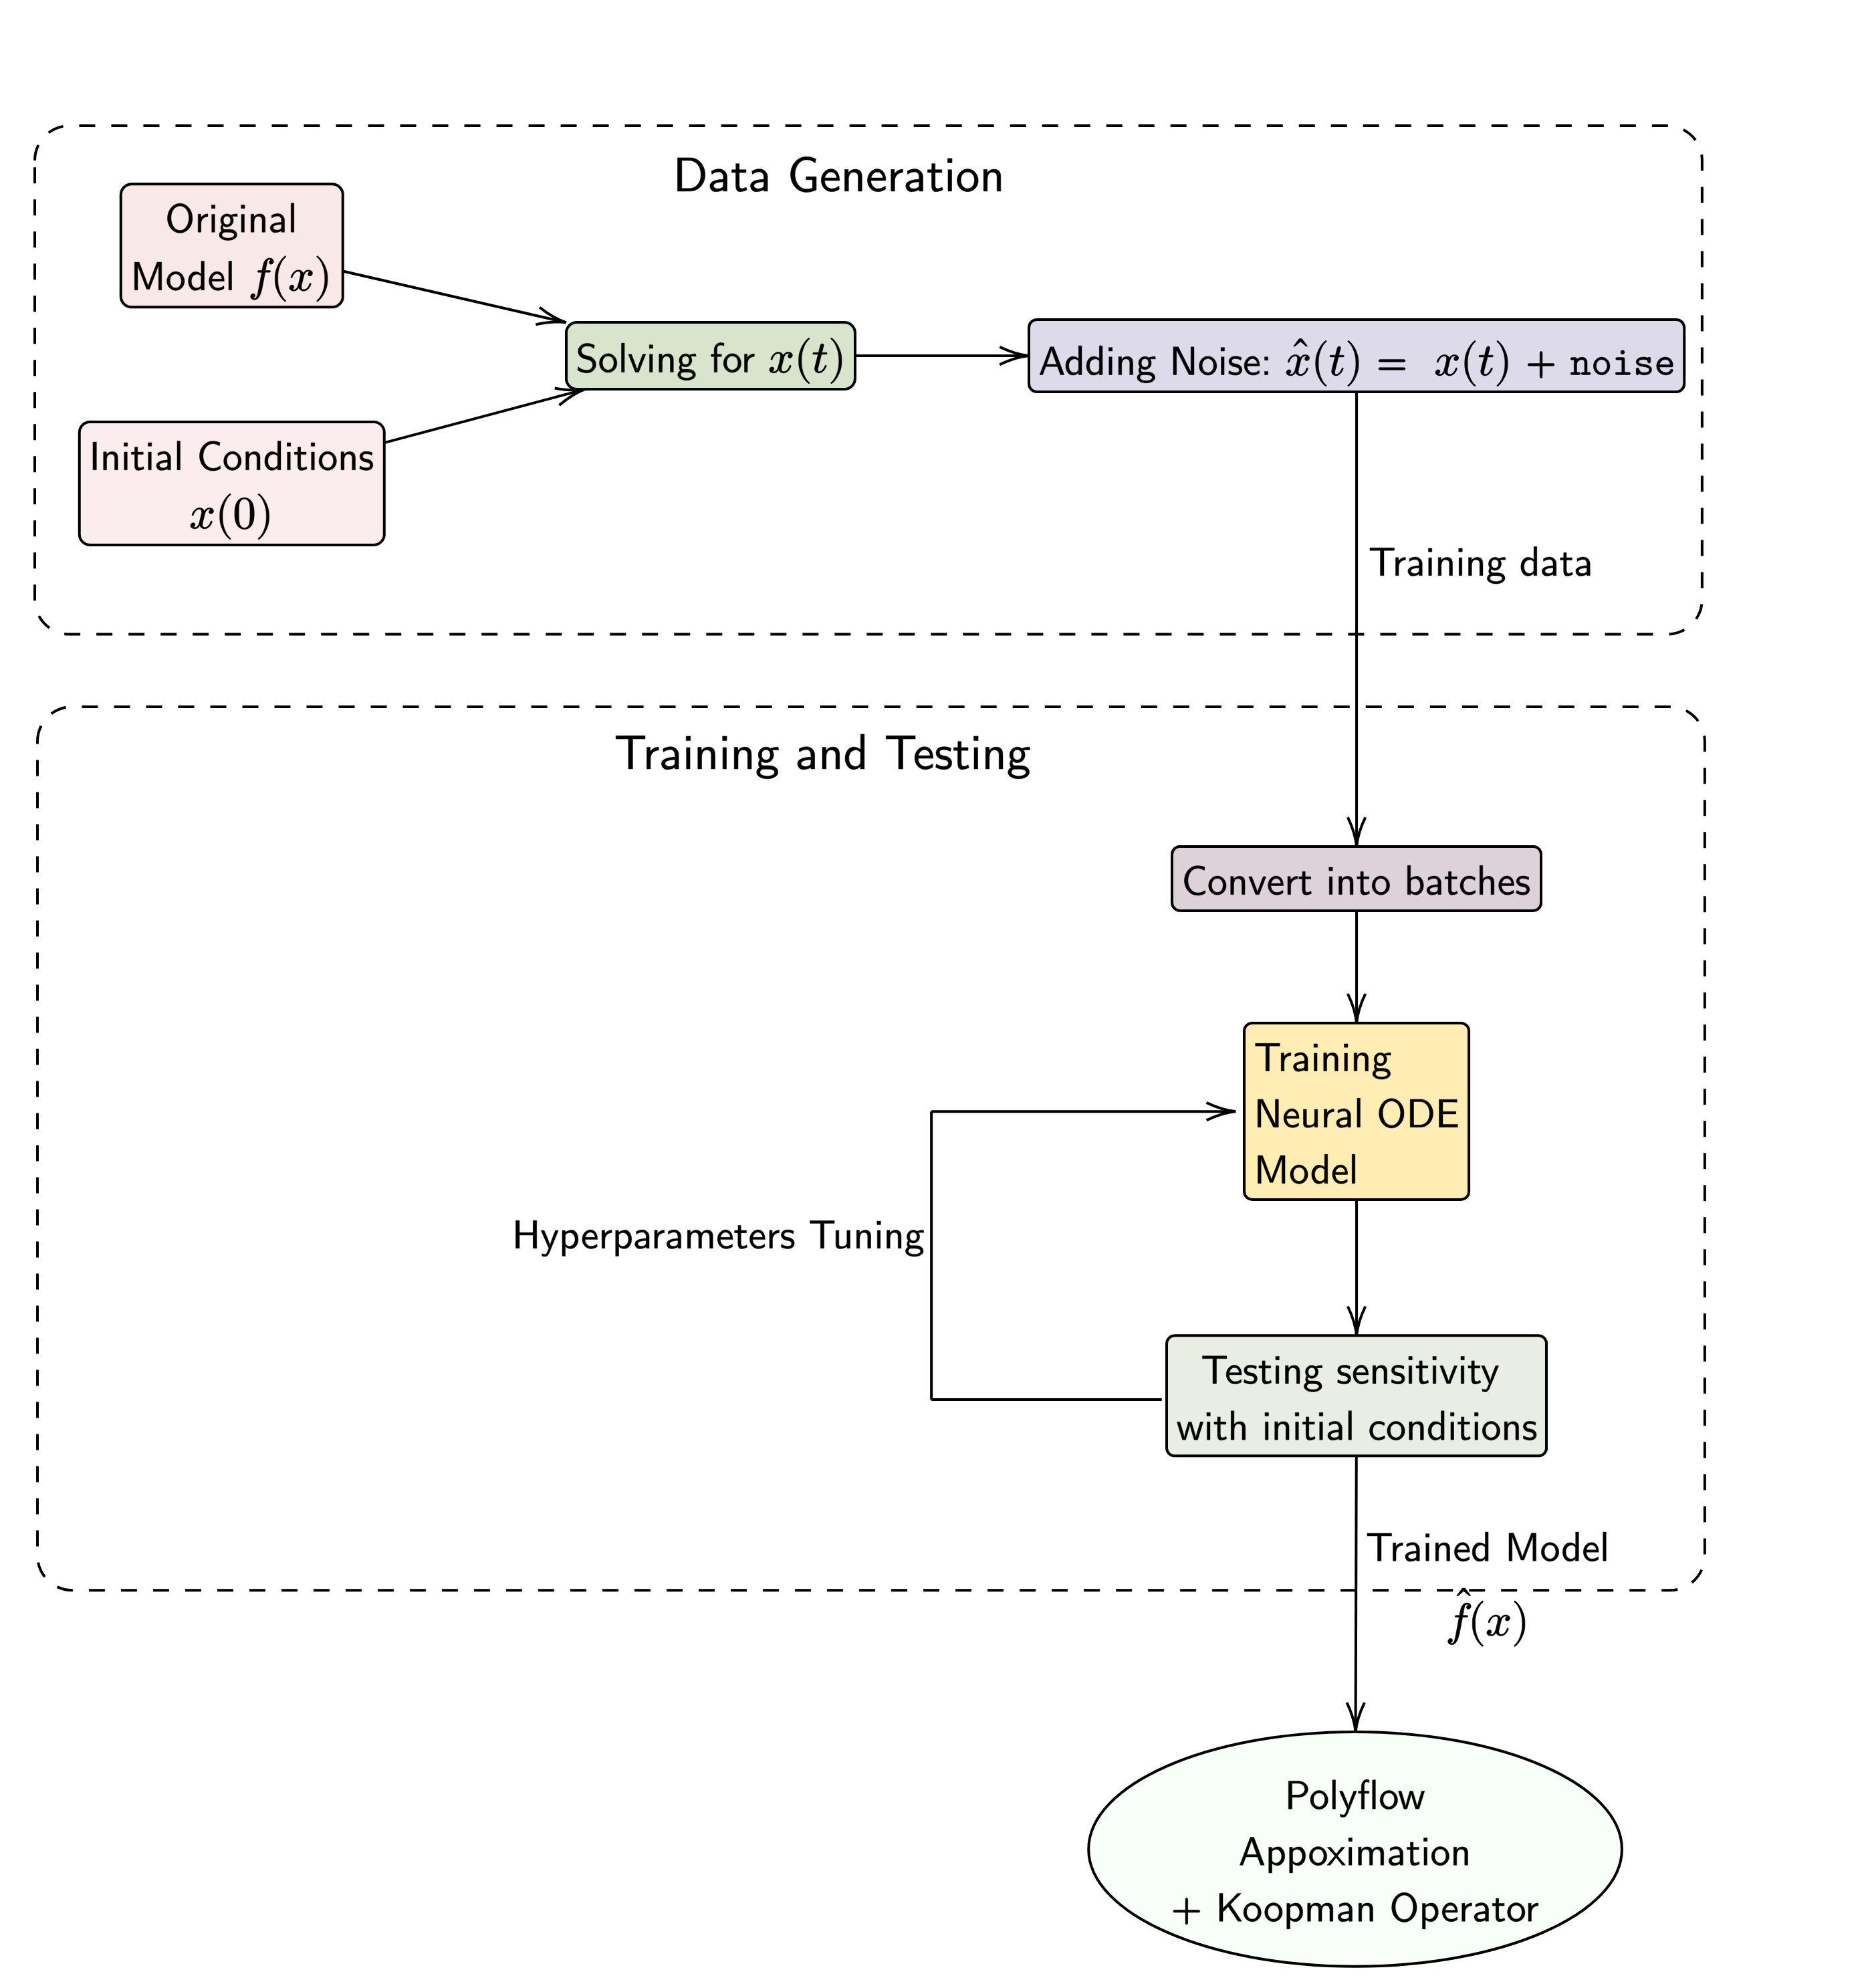

## Datasets and Visualization

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint


### Generating Datasets

In [23]:
data_size = 2000 # time steps = 2000


true_x0s = [torch.tensor([[1., 1.]]).cuda(),
            torch.tensor([[0.5, 1.]]).cuda(),
            torch.tensor([[1., 0.5]]).cuda()]  # Choosing three initial conditions to train on three different trajectories

t = torch.linspace(0., 20., data_size).cuda() # time 


In [24]:
class LotkaVolterra(nn.Module):
    '''
    This is the true LotkaVolterra dynamical System. 
    x1dot = ax1 - bx1x2;
    x2dot = cx1x2 - dx2;
    Where, x1 is prey population, x2 is predator population
    '''
    def __init__(self, a, b, c, d):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def forward(self, t, x):
        x1 = x[0, 0]
        x2 = x[0, 1]
        return torch.tensor([[self.a * x1 - self.b * x1 * x2,
                              self.c * x1 * x2 - self.d * x2]]).cuda()

true_xs = [] # This will contain x(t) for different x(0) conditions

for true_x0 in true_x0s:
    with torch.no_grad():
        true_x = odeint_adjoint(func=LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0 = true_x0, t = t)
        true_xs.append(true_x)



In [25]:
noisy_xs = []

for true_x in true_xs:
    # specify the standard deviation of the noise
    noise_stddev = 0.01
    # generate random noise tensor with the same shape as true_y
    noise = (torch.randn(true_x.shape) * noise_stddev).cuda()
    # add the noise to true_y
    noisy_x = true_x + noise
    noisy_xs.append(noisy_x)


### Visualizing datasets

In [26]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})


def visualize(t, true_x, noisy_x=None, pred_x=None, loss = None, filename= None, show = True):
  fig = plt.figure(figsize=(12, 6), facecolor='white')
  ax = fig.add_subplot(121)
  plt.style.use('ggplot')
  ax.set_title('Phase Portrait')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  
  ax2 = fig.add_subplot(122)
  ax2.set_title('Trajectories')
  ax2.set_xlabel('t')
  ax2.set_ylabel('$x_1$,$x_2$')


  t = t.cpu().numpy()

  true_x = true_x.cpu().numpy()
  true_x1 = true_x[:, 0, 0]
  true_x2 = true_x[:, 0, 1]
  ax.plot(true_x1, true_x2, 'blue')
  ax2.plot(t, true_x1,'b-', label = f'x_1')
  ax2.plot(t, true_x2, 'g-', label=f'x_2')
  
  ax2.legend()
    
  ax.plot([], [], 'blue', label='true trajectory')

  if noisy_x is not None:
    noisy_x = noisy_x.cpu().numpy()
    noisy_x1 = noisy_x[:, 0, 0]
    noisy_x2 = noisy_x[:, 0, 1]
    ax.scatter(noisy_x1, noisy_x2, color='blue', s=1)
    ax.scatter([], [], color='blue', label='sampled data', s=1)

  if pred_x is not None:
    pred_x = pred_x.cpu().numpy()
    pred_x1 = pred_x[:, 0, 0]
    pred_x2 = pred_x[:, 0, 1]
  
    ax.plot(pred_x1, pred_x2, 'red')
    ax2.plot(t, pred_x1,'b--', label=f'x_1 (predicted)')
    ax2.plot(t, pred_x2, 'g--', label=f'x_2 (predicted)')
    ax2.legend()

    ax.plot([], [], 'red', label='Predicted trajectory')
 


  ax.set_xlim(true_x1.min() * 0.8, true_x1.max() * 1.2)
  ax.set_ylim(true_x2.min() * 0.8, true_x2.max() * 1.2)

  ax2.set_xlim(t.min(), t.max())
  ax2.set_ylim(true_x.min() * 0.8, true_x.max() * 1.2)
  ax.legend()
  ax2.grid(True)
  if show:
    plt.show()
  if filename is not None:
    fig.savefig(f'./images/{filename}.png')
    plt.close(fig)


In [27]:
fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = fig.add_subplot(111)

for noisy_x in noisy_xs:
    ax.set_title('Phase Portrait')
    ax.set_xlabel('$x_1$ Prey Population')
    ax.set_ylabel('$x_2$ Predator Population')
    noisy_x = noisy_x.cpu().numpy()
    noisy_x1 = noisy_x[:, 0, 0]
    noisy_x2 = noisy_x[:, 0, 1]
    ax.scatter(noisy_x1, noisy_x2, color='blue', s=1)
    ax.set_xlim(noisy_x1.min() * 0.8, noisy_x1.max() * 1.2)
    ax.set_ylim(noisy_x2.min() * 0.8, noisy_x2.max() * 1.2)

ax.scatter([], [], color='blue', label='sampled data')
ax.legend()

fig.savefig(f'./images/phase_portraits.png', dpi=300, bbox_inches='tight')
# plt.close(fig)



initial condition 1


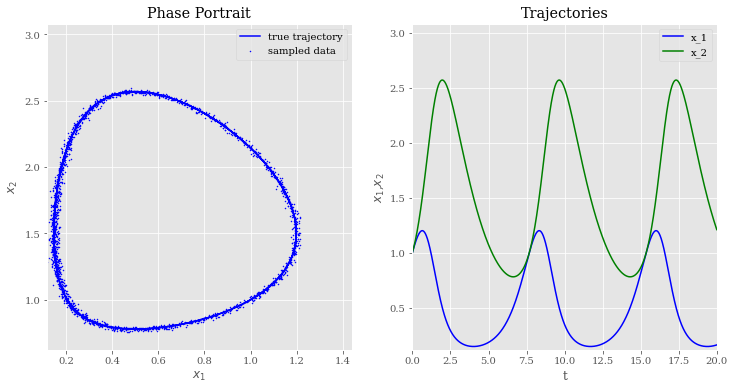

initial condition 2


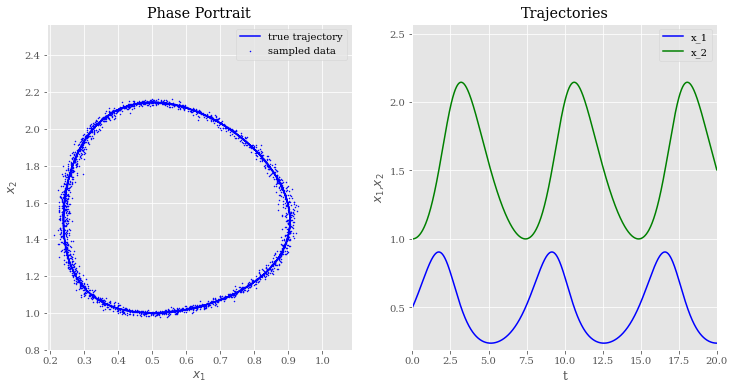

initial condition 3


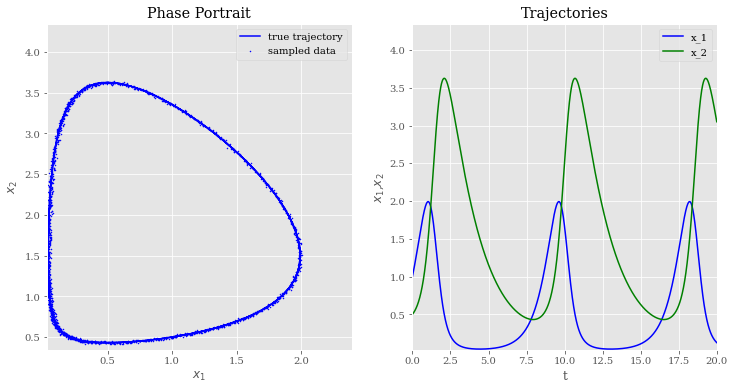

In [28]:
%matplotlib inline
for i, (true_x, noisy_x) in enumerate(zip(true_xs, noisy_xs)):
  print(f'initial condition {i+1}')
  visualize(t, true_x, noisy_x, filename=f'data_ic{i}')


## Training

In [18]:
class PredictedLotkaVolterra(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 32),
                             nn.SiLU(),
                             nn.Linear(32, 32),
                             nn.SiLU(),
                             nn.Linear(32, 2))
  def forward(self, t, y):
    output = self.net(y)
    return output


In [19]:
batch_time = 100
batch_size = 64


def get_batch():
    batch_xs =[]
    batch_x0s = []
    batch_ts = []
    for noisy_x in noisy_xs:
        
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
        batch_x0 = noisy_x[s]  # (batch_size, 1, emb)
        batch_t = t[:batch_time]  # (T)
        # (time, batch_size, 1, emb)
        batch_x = torch.stack([noisy_x[s + i] for i in range(batch_time)], dim=0)
        batch_xs.append(batch_x.cuda())
        batch_x0s.append(batch_x0.cuda())
        batch_ts.append(batch_t.cuda())

    return batch_x0s, batch_ts, batch_xs  


In [20]:
# batch_x0s, batch_ts, batch_xs =get_batch()

In [21]:
%matplotlib agg

# Train
niters = 500

model = PredictedLotkaVolterra().cuda()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

start_time = time.time()
loss_history = []
time_history = []
for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_x0s, batch_ts, batch_xs = get_batch()
  for batch_x0, batch_t, batch_x in zip(batch_x0s, batch_ts, batch_xs):
    pred_x = odeint_adjoint(func=model, y0=batch_x0, t=batch_t,
                          rtol=1e-7, atol=1e-9, method='dopri5')
    loss = torch.mean(torch.abs(pred_x - batch_x))
    loss.backward()
    optimizer.step()
    timecomp = time.time() - start_time
    time_history.append(timecomp)
    loss_history.append(loss.item())

  if iter % 10 == 0:
    for i, (true_x0, noisy_x, true_x) in enumerate(zip(true_x0s, noisy_xs, true_xs)) :
      with torch.no_grad():
        pred_x = odeint_adjoint(model, true_x0, t, rtol=1e-7,
                              atol=1e-9, method='dopri5')
        visualize(t, true_x, noisy_x, pred_x,
                  filename=f'iter_{iter:04d}_ic{i}', show=False)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))


  0%|          | 0/501 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
PATH = "model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history' : loss_history
}, PATH)


### Results of Training

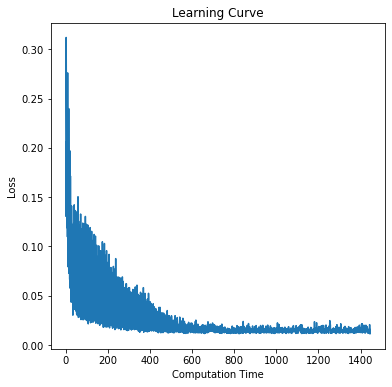

In [ ]:
# Learning curve
%matplotlib inline
fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = fig.add_subplot(111)

ax.set_title('Learning Curve')
ax.set_xlabel('Computation Time')
ax.set_ylabel('Loss')

ax.plot(time_history, loss_history)
fig.savefig('Learning_curve.png')


In [ ]:
# Making gifs

import os
from PIL import Image, ImageDraw, ImageFont

import glob

for ic in range(3):
    frames = []
    imgs = sorted(glob.glob(f"images/iter_*_ic{ic}.png"))
    for i in imgs:
        new_frame = Image.open(i)
        draw = ImageDraw.Draw(new_frame)
        filename = os.path.basename(i)

        font_size = 24
        font = ImageFont.truetype(
            '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', font_size)
        # Draw the text on the image
        name = filename.replace('.png', '')
        draw.text((30, 30), name, font=font, fill=(0, 0, 0))
        new_frame.save("images/"+filename, format='PNG')
        frames.append(new_frame)

    frames[0].save(f'ic{ic}.gif', format='GIF', append_images=frames[1:],
                   save_all=True,
                   duration=300,
                   loop=0)


## Testing

In [ ]:
# Choosing 2x3 initial values from the training datasets 
s = torch.from_numpy(np.random.choice(np.arange(data_size), 2, replace=False))
test_x0s_inside = [] 

for noisy_x in noisy_xs:
    test_x0 = noisy_x[s]
    test_x0s_inside.append(test_x0)
test_x0s_inside = torch.cat(test_x0s_inside, dim=0)

In [ ]:
import torch


def randbetween(lb, ub):
    # Create a tensor of shape (1, 2) with values between 0 and 1
    tensor_2d = torch.zeros(1, 2).uniform_(lb, ub)
    return tensor_2d.cuda()



test_x0s_outside = [randbetween(0,5) for _ in range(6)]
test_x0s_outside


[tensor([[2.0426, 2.6798]], device='cuda:0'),
 tensor([[1.3006, 1.5857]], device='cuda:0'),
 tensor([[0.1728, 3.8389]], device='cuda:0'),
 tensor([[3.4706, 3.5514]], device='cuda:0'),
 tensor([[3.0105, 4.3972]], device='cuda:0'),
 tensor([[4.6948, 1.0002]], device='cuda:0')]

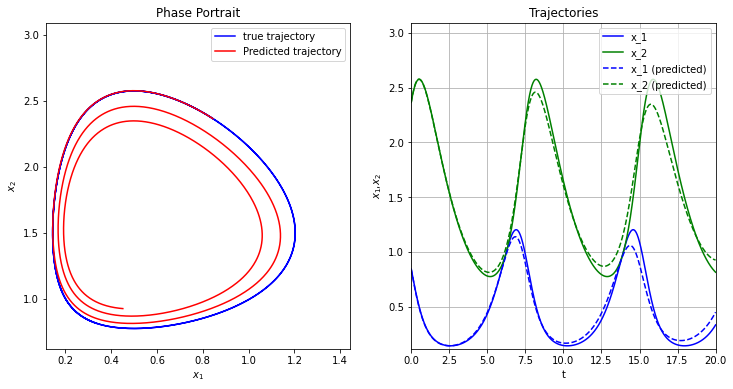

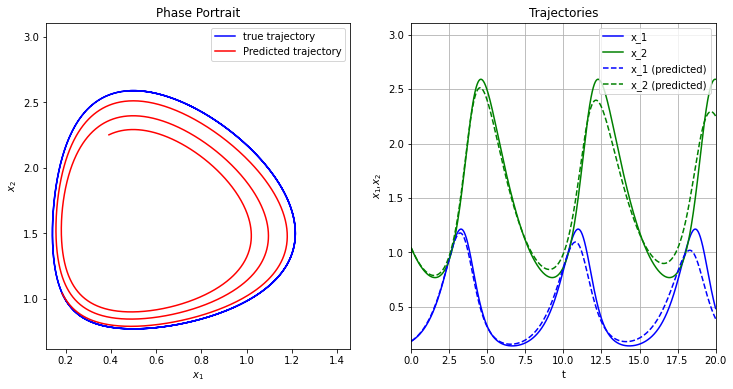

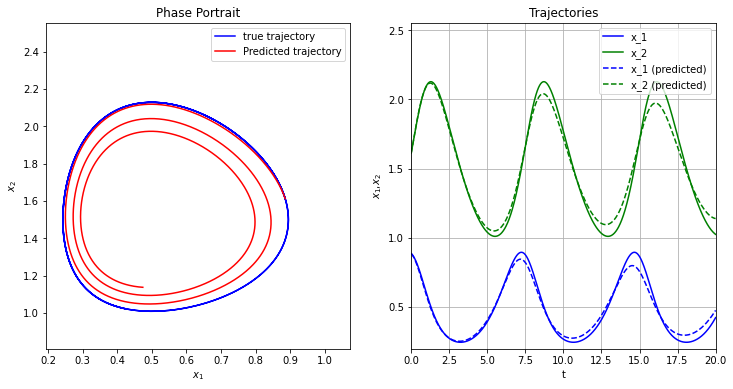

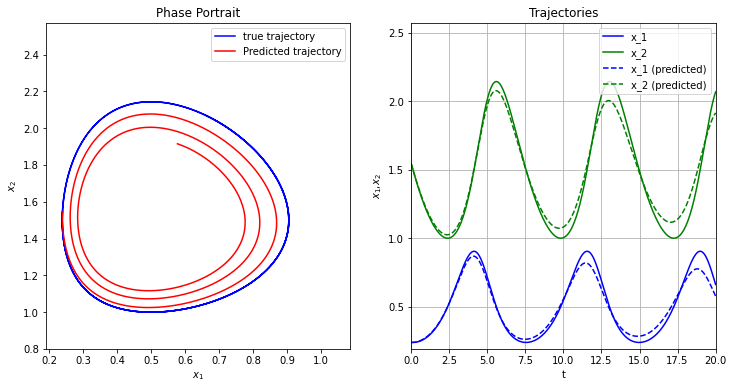

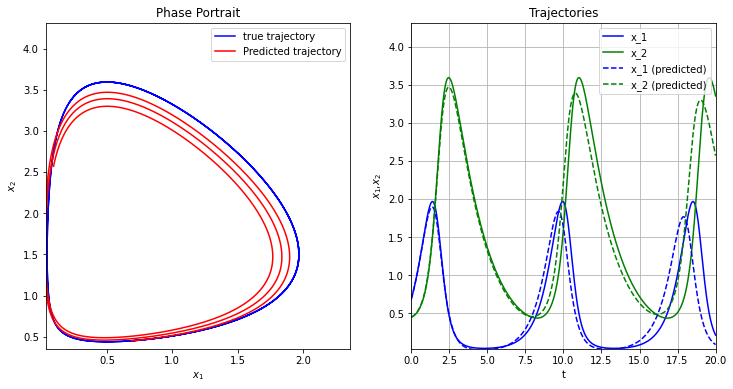

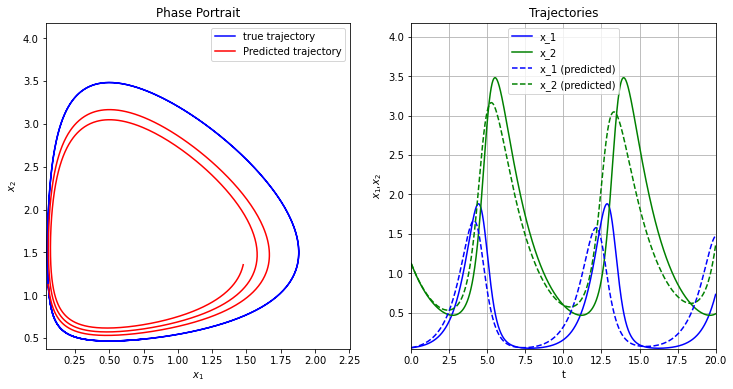

In [ ]:
%matplotlib inline
for i, test_x0 in enumerate(test_x0s_inside):
    with torch.no_grad():
        true_x = odeint_adjoint(LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0 = test_x0, t=t, rtol=1e-7, atol = 1e-9, method='dopri5')
        test_x = odeint_adjoint(model, test_x0, t, rtol=1e-7,
                                atol=1e-9, method='dopri5')
        visualize(t= t, true_x = true_x, pred_x = test_x, filename=f'test{i+1}')


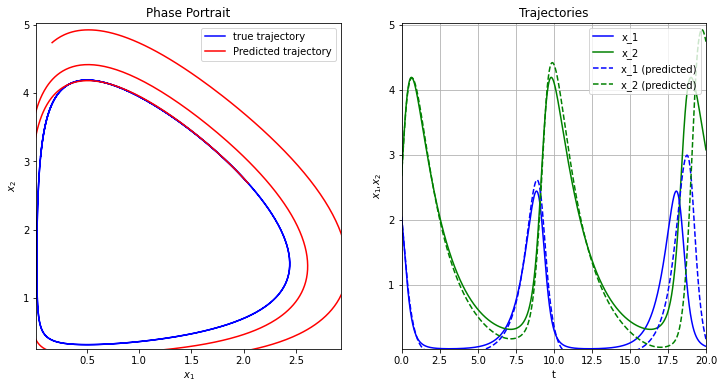

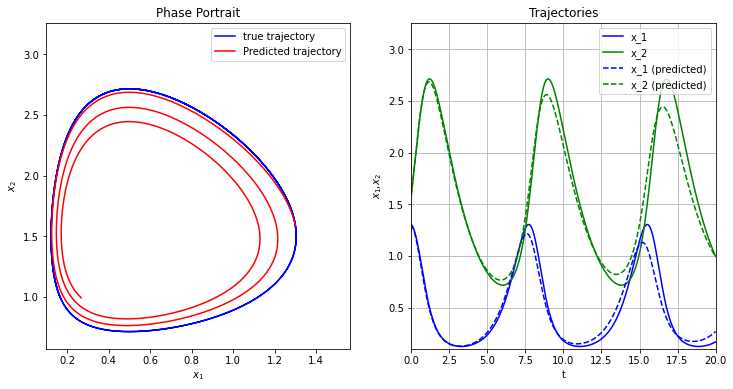

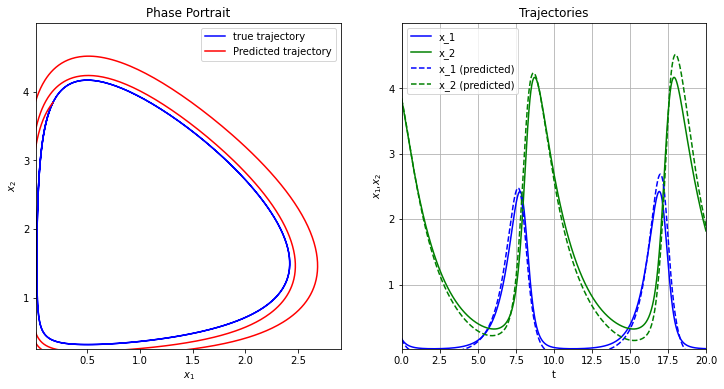

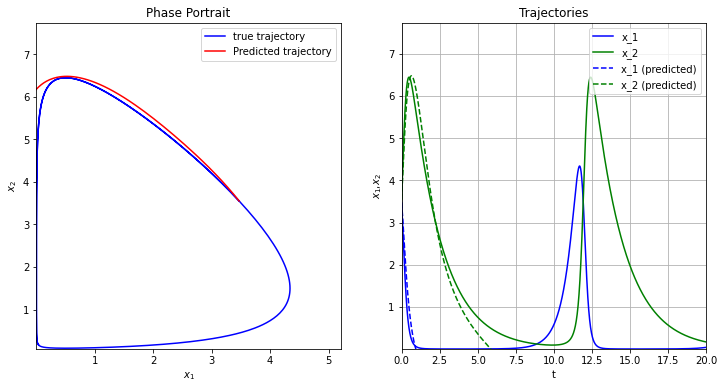

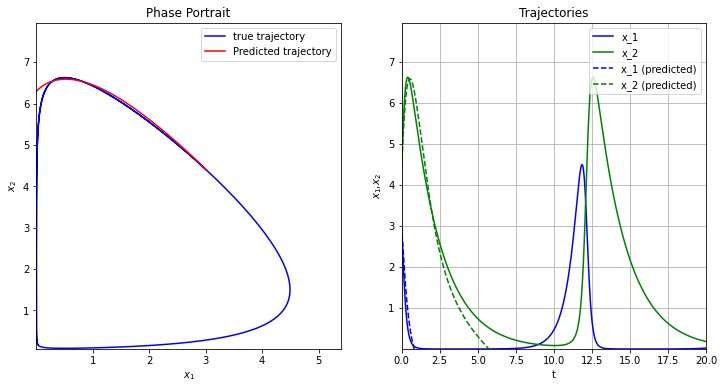

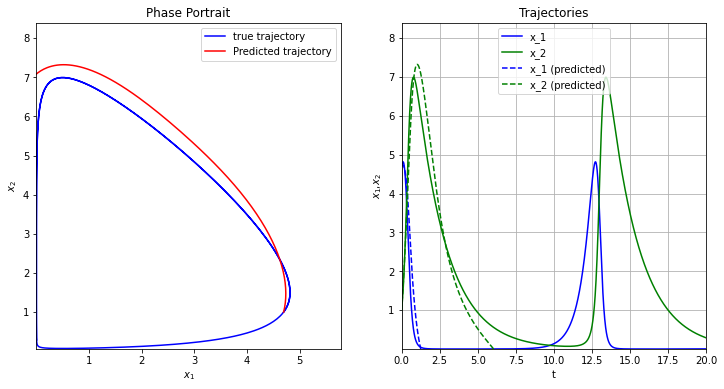

In [ ]:
t = torch.linspace(0,20,2000).cuda()
for i, test_x0 in enumerate(test_x0s_outside):
    with torch.no_grad():
        true_x = odeint_adjoint(LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0=test_x0, t=t, rtol=1e-7, atol=1e-9,
                                method='dopri5')
        test_x = odeint_adjoint(model, test_x0, t, rtol=1e-7,
                                atol=1e-9, method='dopri5')
        visualize(t=t, true_x=true_x, pred_x=test_x, filename=f'test{i+6}')


In [ ]:
def remove_all(folder_path="./", ext=".png"):
    import os
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file extension is .png
        if filename.endswith(ext):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Delete the file
            os.remove(file_path)

# remove_all(folder_path="images/",ext=".png")

In [ ]:
from IPython.display import HTML

# Create an HTML image tag that references the GIF file
gif0 = '<img src="ic0.gif">'
gif1 = '<img src="ic1.gif">'
gif2 = '<img src="ic2.gif">'
# Display the HTML tag in the notebook output area
HTML(gif0)




In [ ]:
HTML(gif2)


In [ ]:
HTML(gif1)


## Calculating Lie Derivatives

In [ ]:
import torch
import torch.nn as nn


class PredictedLotkaVolterra(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 32),
                             nn.SiLU(),
                             nn.Linear(32, 32),
                             nn.SiLU(),
                             nn.Linear(32, 2))

  def forward(self, t, y):
    output = self.net(y)
    return output


lv = PredictedLotkaVolterra().cuda()

x = torch.tensor([[1., 1.]]).cuda()

chck = torch.load('model.pth')
lv.load_state_dict(chck['model_state_dict'])

# Define time points and initial state
t = torch.tensor([0.0, 1.0]).cuda()


In [ ]:
x = torch.tensor([[1.0,1.0]]).cuda()

In [ ]:
def Lf1(x, model=lv, t=torch.tensor([0.0]).cuda()):
    def f(x):
        return model(t, x)
    Lf = f(x)
    return Lf


Lf1(x).shape


torch.Size([1, 2])

In [ ]:

def Lf2(x, model=lv, t=torch.tensor([0.0]).cuda()):
    def f(x):
        return model(t, x)
    J = torch.autograd.functional.jacobian(f, x).squeeze()
    Lf = torch.matmul(J, f(x).t())
    # Lf = Lf.squeeze()
    return Lf.t()


Lf2(x).shape


torch.Size([1, 2])

In [ ]:


def Lf3(x, model=lv, t=torch.tensor([0.0]).cuda()):
    def f(x):
        return model(t, x)
    V = Lf2(x)
    J = torch.autograd.functional.jacobian(Lf2, x).squeeze()
    Lf = torch.matmul(J, f(x).t())
    # Lf = Lf.squeeze()
    return Lf.t()


Lf3(x).shape


torch.Size([1, 2])

In [ ]:
def Lf4(x, model=lv, t=torch.tensor([0.0]).cuda()):
    def f(x):
        return model(t, x)
    V = Lf3(x)
    J = torch.autograd.functional.jacobian(Lf3, x).squeeze()
    Lf = torch.matmul(J, f(x).t())
    # Lf = Lf.squeeze()
    return Lf.t()


Lf4(x).shape


torch.Size([1, 2])

## Creating Gridspace

In [ ]:
def gridspace(lb, ub, num_points):
    x1 = torch.linspace(lb, ub, num_points).unsqueeze(0).cuda()
    x2 = torch.linspace(lb, ub, num_points).unsqueeze(0).cuda()

    # Create 2D grids of x1 and x2 values
    X1, X2 = torch.meshgrid(x1[0], x2[0],  indexing="ij")
    X1 = X1.reshape(-1, 1)                # Reshape to (10000, 1)
    X2 = X2.reshape(-1, 1)                # Reshape to (10000, 1)
    # Stack X1 and X2 tensors along the second dimension
    x = torch.stack([X1, X2], dim=1)
    x = x.squeeze()
    return x


X = gridspace(0, 3, 10)


In [ ]:
def apply(f, X):
    Lf1s =[]
    for i in range(X.shape[0]):
        a= f((X[i,:][:,None]).t())
        Lf1s.append(a)
    A = torch.stack(Lf1s, dim=1).squeeze()
    return A



In [ ]:
apply(Lf1, X)

tensor([[ 1.2511e-01, -1.1909e-01],
        [ 7.7975e-02, -2.2734e-01],
        [ 4.4070e-02, -3.5429e-01],
        [ 2.1863e-02, -4.9691e-01],
        [ 8.0094e-03, -6.5053e-01],
        [-2.3179e-03, -8.0933e-01],
        [-1.4718e-02, -9.6711e-01],
        [-3.4677e-02, -1.1180e+00],
        [-6.6749e-02, -1.2574e+00],
        [-1.1402e-01, -1.3819e+00],
        [ 5.2564e-01, -2.3243e-02],
        [ 4.0319e-01, -5.9695e-02],
        [ 2.8477e-01, -1.0482e-01],
        [ 1.7034e-01, -1.5702e-01],
        [ 5.8934e-02, -2.1398e-01],
        [-5.1199e-02, -2.7307e-01],
        [-1.6221e-01, -3.3173e-01],
        [-2.7621e-01, -3.8783e-01],
        [-3.9483e-01, -4.3988e-01],
        [-5.1905e-01, -4.8701e-01],
        [ 9.7429e-01,  3.4273e-02],
        [ 7.7044e-01,  7.3879e-02],
        [ 5.5718e-01,  1.1922e-01],
        [ 3.3607e-01,  1.7061e-01],
        [ 1.0945e-01,  2.2732e-01],
        [-1.1969e-01,  2.8737e-01],
        [-3.4801e-01,  3.4782e-01],
        [-5.7238e-01,  4.053

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from scipy.linalg import expm



In [ ]:
P0 = X
P1 = apply(Lf1, X)
P2 = apply(Lf2, X)
P3 = apply(Lf3, X)
P4 = apply(Lf4, X)


In [ ]:
P_N3 = torch.cat([P0, P1, P2, P3], dim=1)
P_N2 = torch.cat([P0, P1, P2], dim = 1)
P_N1 = torch.cat([P0, P1], dim = 1)


In [ ]:
L4 = torch.linalg.lstsq(P_N3, P4)
L3 = torch.linalg.lstsq(P_N2, P3)
L2 = torch.linalg.lstsq(P_N1, P2)
L1 = torch.linalg.lstsq(P0,P1)


In [ ]:
L2[0].t().cpu()

tensor([[ 35.3518, -11.5180, -23.5656, -25.6171],
        [-34.8864,  11.3834,  24.7683,  24.7737]], grad_fn=<ToCopyBackward0>)

In [ ]:
def getMatrixA(L, N, n=2):
    A = torch.cat([torch.zeros((2*N-n, n)), torch.eye(2*N-n, 2*N-n)], dim=1).cuda()
    A = torch.cat([A, L[0].t()],dim=0)
    return A

A2 = getMatrixA(L2,2)
A2

tensor([[  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000],
        [ 35.3518, -11.5180, -23.5656, -25.6171],
        [-34.8864,  11.3834,  24.7683,  24.7737]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [ ]:
x0 = torch.tensor([[1.0, 1.0]]).cuda()
xi0_N2 = [x0, Lf1(x0)]

xi0_N2 = torch.cat(xi0_N2, dim=1)
xi0_N2

tensor([[1.0000, 1.0000, 0.5052, 0.4922]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [ ]:
from torchdiffeq import odeint
# Define the system of ODEs
def dynamics_fn(t, x):
    return torch.matmul(A2, x)


# Define the time range and number of datapoints
t0, t1 = 0.0, 20.0
num_points = 2000
t = torch.linspace(t0, t1, num_points).cuda()

# Solve the ODEs using odeint
# Set the tolerances for numerical integration
atol = 1e-6
rtol = 1e-4
x = odeint(dynamics_fn, xi0_N2.t(), t, atol=atol, rtol=rtol, method='dopri5')


In [ ]:
x = x.squeeze()
x.shape
x1 = x[:, 0].cpu().numpy()
x2 = x[:, 1].cpu().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
t = t.cpu().numpy()

In [ ]:
true_x = true_xs[0]
true_x1 = true_x[:,0,0].cpu().numpy()
true_x2 = true_x[:, 0, 1].cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6), facecolor='white')
plt.style.use('ggplot')
ax = fig.add_subplot(111)
ax.plot(t, true_x1, '-b', t, true_x2, '-g', t,x1, '--b', t, x2, '--g')
# plt.xlim([0,3])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Trajectories')
ax.set_ylim([-2,4])
ax.legend(['x1','x2', 'x1 (polyflow N=2)', 'x2 (polyflow N=2)'])
fig.savefig('polyflow_neural.png')

AttributeError: 'Figure' object has no attribute 'style'

<Figure size 432x432 with 0 Axes>